In [26]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.special import legendre
from numpy.polynomial.legendre import Legendre

# Legendre polynomial
def leg(n, x): 
    return Legendre(np.concatenate((np.zeros(n), np.array([1]))))(x)

def hbasis(i,x):
#  Evaluates the function Ni(y) at x
#  In function L(y) i-2 is the degree of the legendre polynomial
    if i==0:
        Ni=0.5 *(1-x)
    elif i==1:
        Ni=0.5 *(1+x)
    else:
        Ni=(np.sqrt(1/(4*(i+1)-6)))*(leg(i,x)-leg(i-2,x))
    return Ni

def stifness_matrix(p):
#evaluates the elemental stifness matrix of size (p+1)x(p+1)
    K=np.zeros((p+1,p+1))
    K[0,0]=K[1,1]=0.5
    K[0,1]=K[1,0]=-0.5
    if p>=1:
        for i in range(2,p+1):
            K[i,i]=1
    return K

def mass_matrix(p):
# Evaluates the elemental mass matrix of size (p+1)x(p+1)
    G=np.zeros((p+1,p+1))
    G[0,0]=G[1,1]=2/3
    G[0,1]=G[1,0]=1/3
    if p>=2:
        G[0,2]=G[1,2]=G[2,0]=G[2,1]=-1/np.sqrt(6)
        for i in range(2,p+1):
            G[i,i]=2/((2*(i+1)-1)*((2*(i+1)-5)))
    if p>=3:
        G[0,3]=G[3,0]=1/3*np.sqrt(10)
        G[1,3]=G[3,1]=-1/3*np.sqrt(10)
        for i in range(2,p+1):
            if i+2<p+1:
                G[i,i+2]=G[i+2,i]=(-1)/(((2*(i+1)-1)*np.sqrt(((2*(i+1)-3)*((2*(i+1)+1))))))
    return G

def load_vector(p,f,l,c):
#Evaluates the element load vector
    vals=[]
    for i in range(p+1):
        g = lambda x : f(x,l,c)*hbasis(i,x)
        vals.append(integrate.quad(g,-1,1)[0])
    b=np.array(vals)
    return b

def fem_solution(p,f,x,l,c):
# Evaluates the finite element method solution and the coifficients that generate the solution
    K=stifness_matrix(p)[2:,2:]
    G=mass_matrix(p)[2:,2:]
    A=K+c*G
    b=load_vector(p,f,l,c)[2:]
    a=np.linalg.solve(A,b)
    ufe_array = np.zeros((p-1, x.shape[0]))
    for i in range(2,p+1):
        for j,val in enumerate(x):
            ufe_array[i-2,j] = a[i-2]*hbasis(i,val)
    ufe_values = np.array([np.sum(ufe_array[:,j]) for j in range(x.shape[0])])
    return a, ufe_values

def energy_norm(p,f,x,l,c):
# Evaluates the energy norm of the finite element method solution and it finds 
# the percentage of the error
    a=fem_solution(p,f,x,l,c)[0]
    enorm = np.dot(a, np.array(load_vector(p,f,l,c)[2:]))
    y = lambda x : ((1-x)*(1+x)**l)*f(x,l,c)
    enorm_uex=integrate.quad(y,-1,1)[0]
    err=np.sqrt(abs(enorm-enorm_uex)/abs(enorm_uex))
    return enorm, err

def main():
    f = lambda x,l,c : (l*(x+1)**(l-2))*((1+l)*x-l+3)+c*((x+1)**(l)*(1-x))
    l_list=[8.7,4.4,2.9,1.2]
    fig, axes = plt.subplots(1,4, figsize=(15,7))
    fig.tight_layout()
    for i,l in enumerate(l_list):
        c=1
        p_list=[2,3,4,5,6,7,8]
        errors=[]
        x = np.linspace(-1,1,1001)
        for p in p_list:
            errors.append(energy_norm(p,f,x,l,c)[1])
        slope=((np.log(errors[5])-np.log(errors[6]))/(np.log(p_list[5])-np.log(p_list[6])))
        print(f"The slope in graph {i+1} is {slope}")
        axes[i].loglog(np.array(p_list)-1,errors) 
        axes[i].set_xlabel("log(DOF)")
        axes[i].set_ylabel("log(E)")
        axes[i].set_title(f"graph{i+1}")

    l=1.1
    c=2
    p=4
    x = np.linspace(-1,1,1001)
    u_Ex_fun = lambda x : (1-x)*((1+x)**l)
    u_Fe = fem_solution(p,f,x,l,c)[1]
    u_Ex_values = [u_Ex_fun(val) for val in x]
    fig , axes =plt.subplots(figsize=(10,10))
    axes.plot(x,u_Fe, color="red")
    axes.plot(x,u_Ex_values, color="blue")
    axes.set_ylim(0,2)
    axes.set_xlabel("x")
    axes.set_ylabel("y")
    axes.set_title(r'Plots of $u_{FE}$ and $u_{EX}$')
    axes.legend([r'$u_{FE}$','$u_{EX}$'])
    fig , axes =plt.subplots(figsize=(10,10))
    axes.plot(x,abs(u_Ex_values-u_Fe),color='black')
    axes.set_xlabel("x")
    axes.set_ylabel("y")
    axes.set_title(r'Error $|u_{FE}-u_{EX}|$')
    

The slope in graph 1 is -15.257583179610187
The slope in graph 2 is -9.766921503901187
The slope in graph 3 is -5.365538041568958
The slope in graph 4 is -1.462092735607912


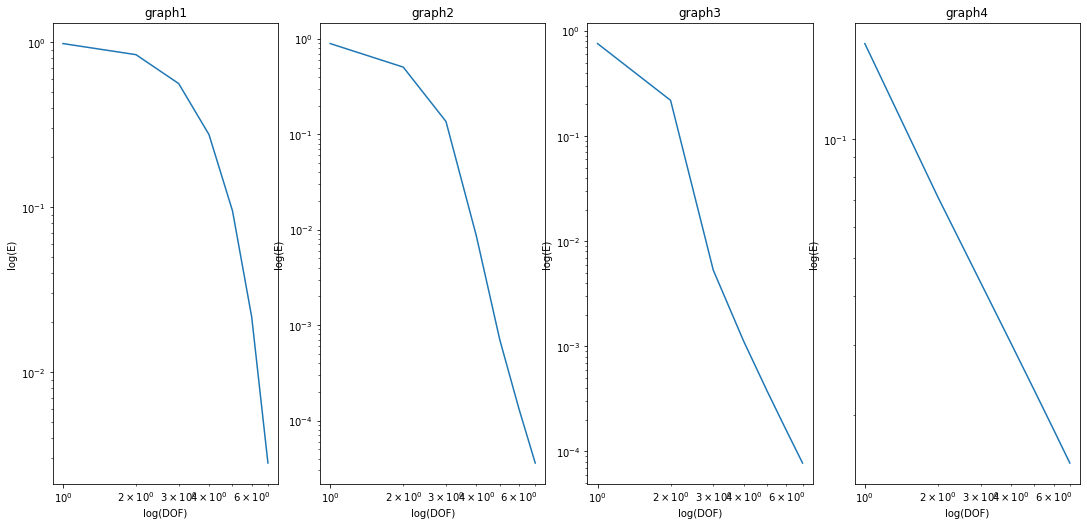

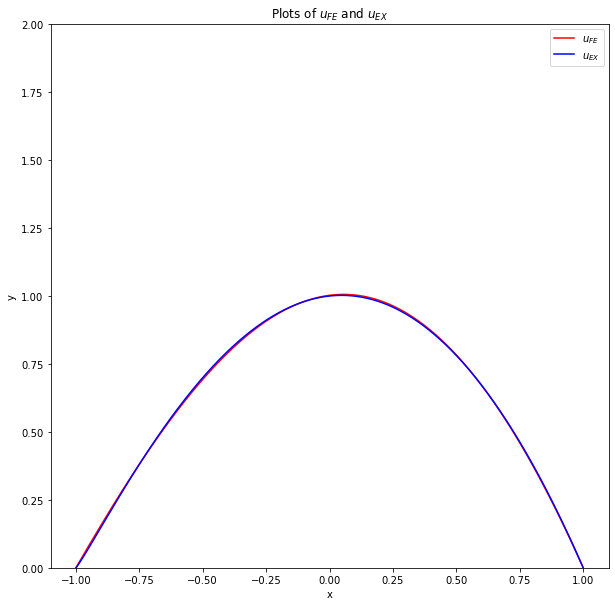

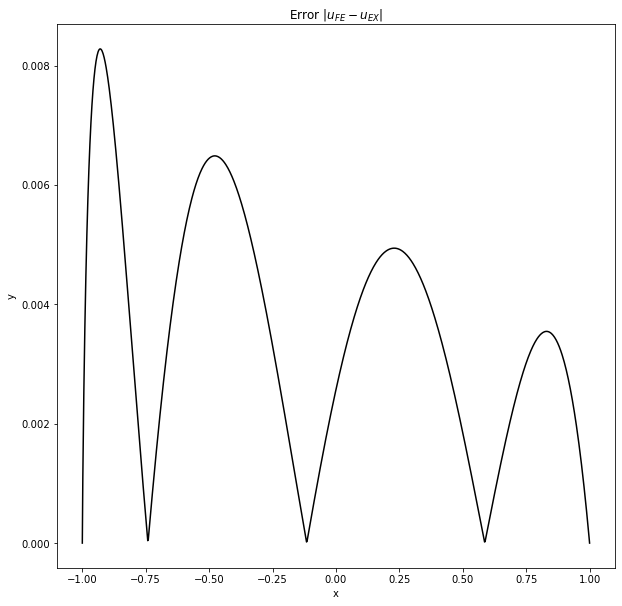

In [27]:
if __name__ == "__main__":
    main()